# BigGAN Assignment

In the class demo we have seen an example where we hold the truncation factor and the noise constant, while smoothly changing the class vector from one class to another. In this assignment, let's explore what will happen if we change the truncation factor and the noise, while holding the class vector constant.

This assignment consists of the following tasks required to achieve the goal described above:

1. Generate 10 different truncation factors in the interval (0, 1].
2. For each truncation factor, generate 5 different noise vectors using that truncation factor.
3. Create one-hot-encoded vector for the class label "mushroom". 
4. Given all the inputs, generate and plot 50 different images of mushrooms.
5. Make a conclusion about relationship between the truncation factor and the model output.

Since this assignment is 20 points, each task is 4 points. Throughout this assignment, you may copy/call any code from the class material, including Jupyter notebooks and utils.py file.

While not required to accomplish this assignment, reading the original paper may help gaining a deeper understanding of this model's inner workings. https://arxiv.org/abs/1809.11096

In [1]:
!bash -l -c "conda activate ucla_deeplearning && pip install tensorflow-estimator==2.2.0"

In [2]:
# Tensorflow module path for 512x512 BigGAN-deep
module_path = 'https://tfhub.dev/deepmind/biggan-deep-512/1'    

# Assignment hyperparameters
factors_count = 10
samples_per_factor = 5
samples_count = factors_count * samples_per_factor

We first read in all the necessary components for the model:

In [3]:
import io
import numpy as np
import pandas as pd
import PIL.Image
import IPython.display
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_hub as hub
from utils import *

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
# Run this cell to configure Tensorflow to use your GPU
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2021-10-20 04:36:58.479832: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-20 04:36:58.544444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 04:36:58.545356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-20 04:36:58.545659: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-20 04:36:58.547663: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-20 04:36:58.549612: I tensorflow/stream_executor/platform/defaul

In [5]:
module = hub.Module(module_path)

inputs = {
    k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
    for k, v in module.get_input_info_dict().items()
}

output = module(inputs)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [6]:
# Tensor z holds the random noise for each image to be generated.
noise_in = inputs['z']
dim_noise = noise_in.shape.as_list()[1]

# Tensor y is the one-hot-encoded class for each image to be generated.
class_in = inputs['y']
dim_class = class_in.shape.as_list()[1]

# Scalar between 0 and 1 that is the truncation factor of the noise.
trunc_in = inputs['truncation']

{n: t.shape for n, t in inputs.items()}

{'y': TensorShape([Dimension(None), Dimension(1000)]),
 'z': TensorShape([Dimension(None), Dimension(128)]),
 'truncation': TensorShape([])}

In [7]:
output

<tf.Tensor 'module_apply_default/G_trunc_output:0' shape=(?, 512, 512, 3) dtype=float32>

In [8]:
sess = tf.Session()

initializer = tf.global_variables_initializer()
sess.run(initializer)

2021-10-20 04:37:48.561127: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-10-20 04:37:48.588536: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2300000000 Hz
2021-10-20 04:37:48.589004: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56322fcd3fb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-20 04:37:48.589029: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-10-20 04:37:48.589440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 04:37:48.590350: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tes

# Task 1

In this task, you need to generate an array of 10 different truncation factors in the interval (0, 1].
Note that factor = 0 is invalid because the distribution collapses to a single possible value. Factor can be as close to zero as you would like, however. 

An excellent idea is to use this function: https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html

Expected shape of the array: `(10,)`

In [9]:
# Enter your code for task 1 here.

# generate 10 truncation factors
# no keyword argument for excluding starting point --> exclude endpoint
# we also reverse the array
trunc_facs = np.linspace(1, 0, 10, endpoint=False)[::-1]
# confirm values and shape
print(trunc_facs)
print(trunc_facs.shape)

# Create additional cells directly below this one, if needed.

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
(10,)


# Task 2

Great, let's make some noise now!

You need to generate an array of noise vectors. However, now is also a good time to talk about the batch size. Recall that the truncation factor is used to generate the noise, but it's also an input to the model itself. Even though the goal is to generate 50 images, the model is using the same truncation factor for all images generated in a single batch. This means that to generate images for 10 different truncation factors, you will need to evaluate the model with 10 separate batches. In summary, you need 10 batches with 5 noise vectors in each batch. 

Useful functions for this task:
* `random.randint`
* `random_noise` from BigGAN.ipynb
* `numpy.concatenate`
* `numpy.reshape`

Expected shape of the array: `(10, 5, 128)`

In [10]:
# function definition for random_noise
from scipy.stats import truncnorm

def random_noise(batch_size=10, truncation_factor=1, truncation_threshold=2, seed=100):
    """
    Returns a 2-d array of random noise.
    
    Normal distribution with mean = 0 and std = 1 is truncated to
    range defined as [-threshold * factor, threshold * factor].
    """
    state = np.random.RandomState(seed)
    
    random_z = truncnorm.rvs(
        -truncation_threshold * truncation_factor, 
        truncation_threshold * truncation_factor, 
        size=(batch_size, dim_noise), 
        random_state=state
    )
    
    return random_z

In [11]:
# Enter your code for task 2 here.

# we want 10 batches with 5 noise vectors in each batch --> batch size is 5
# the 10 batches will be taken care of by the fact that we have 10 elements in the trunc_facs array
batch_size = 5
dim_noise = 128
# we'll start by making an array of zeros in the desired shape
noise = np.zeros((10, batch_size, dim_noise))
# loop through each truncation factor:
for i,fac in enumerate(trunc_facs):

    # first, we use the random_noise function to generate 5 vectors of length 128
    noise_vecs = random_noise(batch_size=batch_size, truncation_factor=fac)
    # insert vectors for the current truncation factor at the appropriate index
    noise[i] = noise_vecs

# confirm shape
print(noise.shape)
# Create additional cells directly below this one, if needed.

(10, 5, 128)


# Task 3

Amazing work! Let's take care of the mushrooms now.

You need a one-hot-encoded array that corresponds to the mushroom class. As we have discussed in the previous task, there will be 10 batches of samples. In each batch, there are 5 samples, but all of them have the same class.

Useful functions for this task:
* `get_classes`
* `class_labels_to_ids`
* `class_ids_to_one_hot`
* `numpy.repeat`

Expected shape of the array: `(10, 5, 1000)`

In [12]:
# function definition for get_classes
def get_classes():
    """
    Returns a Pandas Series, where values are class labels and the index consists of class IDs.
    """
    with open('./biggan_classes.json') as f:
        classes = json.loads(f.read())
    classes = [c.split(') ')[1] for c in classes]
    classes = pd.Series(classes)
    return classes

# function definition for class_labels_to_ids
def class_labels_to_ids(class_labels):
    """
    Converts an iterable of class labels into Numpy array of class IDs.
    
    Expected global variable: classes
    """
    return np.array([(classes == c).idxmax() for c in class_labels])

# function definition for class_ids_to_one_hot
def class_ids_to_one_hot(class_ids):
    """
    Converts a 1-d array of class IDs into 2-d array of one-hot-encoded classes.
    
    Expected global variable: classes
    """
    class_ids = class_ids.reshape(-1, 1)
    class_ohs = class_encoder.transform(class_ids)
    return class_ohs.toarray()

In [13]:
# Enter your code for task 3 here.

from sklearn.preprocessing import OneHotEncoder
import json

# there are 1000 classes
dim_class = 1000

# create and fit global encoder to be used in class_ids_to_one_hot function
class_encoder = OneHotEncoder(categories='auto')
class_encoder.fit(np.arange(dim_class).reshape(-1,1))

# retrieve classes from json file (necessary global variable)
classes = get_classes()
# retrieve class id for mushrooms
class_id = class_labels_to_ids(['mushroom'])

# get the one-hot encoded version of the mushroom class
class_oh = class_ids_to_one_hot(class_id)
# create a one-hot encoded class for each of the batches and reshape
class_oh = np.repeat(class_oh, batch_size, axis=0).reshape((1, batch_size, dim_class))
# we want one sample for each truncation factor
sample_size = 10
# create a one-hot encoded class for each of the 10 truncation factors
class_oh = np.repeat(class_oh, sample_size, axis=0)
# confirm shape
print(class_oh.shape)

# Create additional cells directly below this one, if needed.

(10, 5, 1000)


# Task 4

Very exciting! We are ready to take a walk in the forest.

You now have three arrays (class, noise, factor) with inputs for each of the 10 batches. 

Here are the steps for this task:
1. Iterate over input arrays and feed the Tensorflow model with one batch a time.
2. Collect the output of BigGAN for each batch into a list.
3. Concatenate the list into a single 4-dimensional array of images.
4. Plot the images in a grid.

Running the model should take about 1-2 mins with 8-core CPU. This step will also require up to 10GB of RAM. It's highly recommended to run this in the cloud.

Plot images in a grid, where each row has the same truncation factor but different random noise.

Useful functions for this task:
* `generate_images`
* `numpy.concatenate`
* `plot_strided_grid`

In [14]:
# function definition for generate_images
def generate_images(classes, noises, truncation_factor, batch_size=10):
    """
    Generates the images from given model inputs.
    100 of 512x512 images take ~2 minutes on 8-core CPU.
    
    Computation is performed in batches to avoid running out of RAM.
    Note that the required RAM is an affine function of the batch size.
    From empirical evidence, batch size of 5 with 512x512 images will use ~10GB RAM.
    
    Note that all images are generated with the same truncation factor.
    
    Expected global variables: sess, output
    """
    
    # Count of images to be generated.
    n = classes.shape[0]

    # Indexes of the first image to be generated in each batch.
    starts = np.arange(0, n, batch_size)
    
    outputs = []
    for start in starts:
        batch_idx = slice(start, start+batch_size)
            
        feed_dict = {
            noise_in: noises[batch_idx], 
            class_in: classes[batch_idx], 
            trunc_in: truncation_factor
        }

        outputs.append(sess.run(output, feed_dict=feed_dict))
        
    outputs = np.concatenate(outputs)
    
    # Rescales from floats in [-1, 1] to ints in [0, 255].
    images = ((outputs + 1) * 127).astype('uint')
    
    return images

2021-10-20 04:38:32.559674: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-20 04:38:33.242358: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


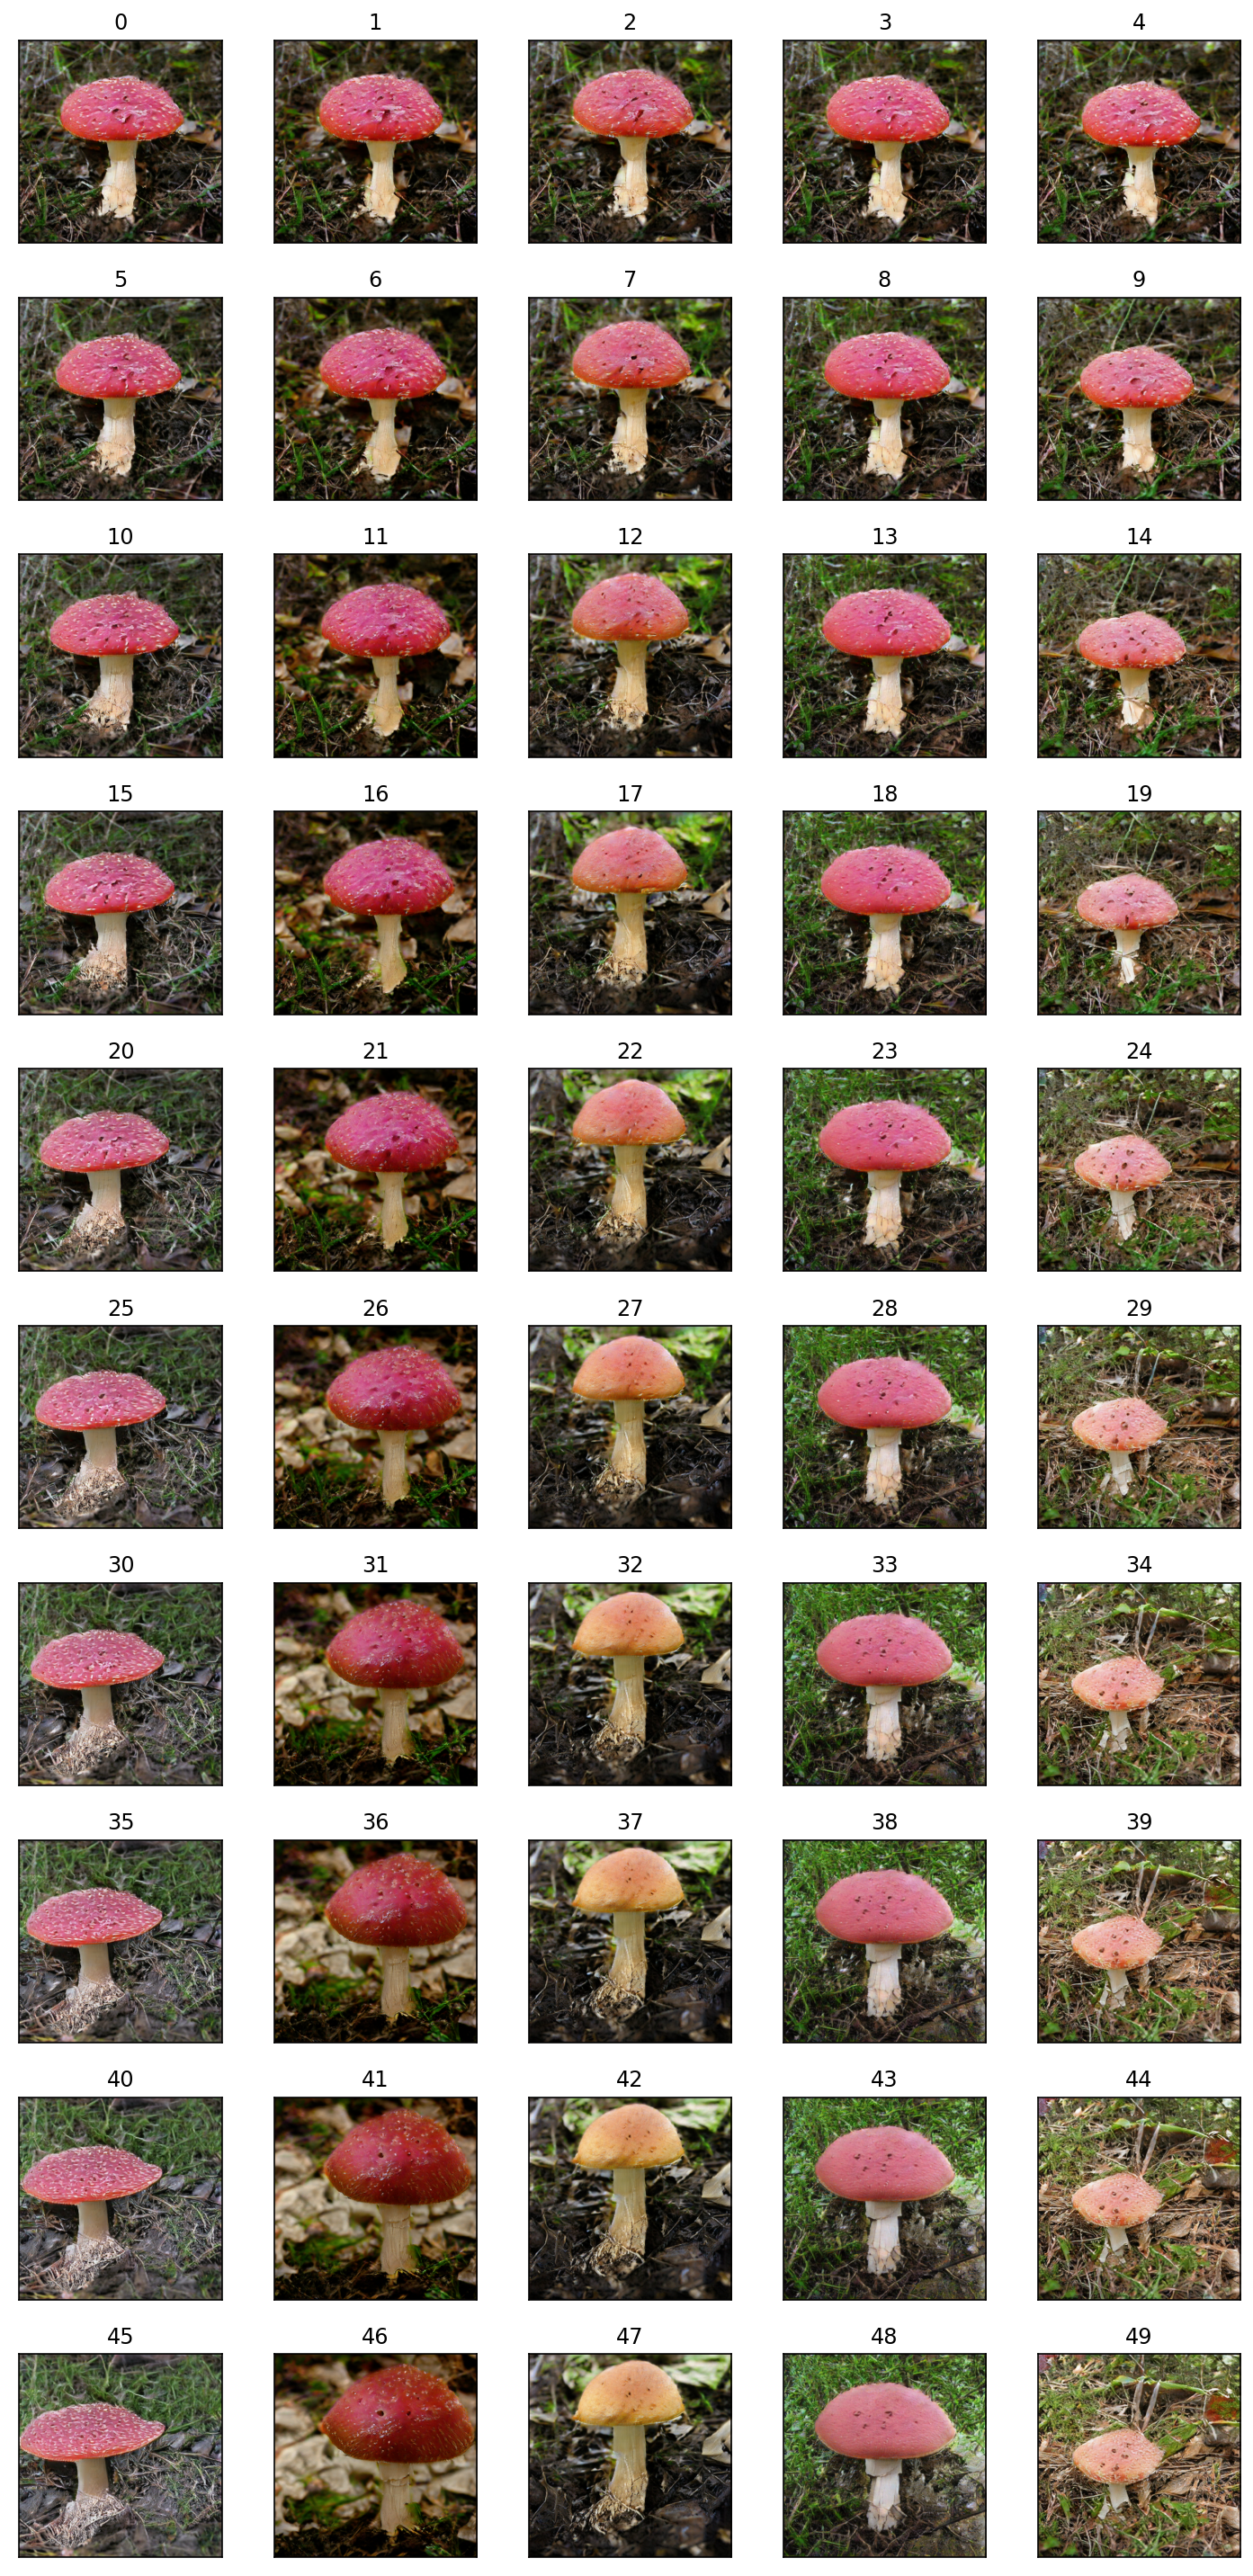

In [15]:
# Enter your code for task 4 here.

# array to store images from each truncation factor
images = []
# loop through each truncation factor
for i,fac in enumerate(trunc_facs):
    
    # grab the noise vectors for the current truncation factor
    noise_curr = noise[i]
    # grab the one-hot encoded classes for the current truncation factor
    class_oh_curr = class_oh[i]
    # generate the images
    images_curr = generate_images(class_oh_curr, noise_curr, fac, batch_size=batch_size)
    # collect images into 4D array
    images.append(images_curr)

# concatenate images
images = np.concatenate(images)
# plot images
plot_strided_grid(images, ncols=5, nrows=10)

# Create additional cells directly below this one, if needed.

# Task 5

Wow, so many mushrooms. 

This has been an amazing adventure, let's make some conclusions.
Here are some questions that you should answer, but also feel free to add any other thoughts that you have: <br>
1. What's the relationship between truncation and image diversity?
2. What's the relationship between truncation and image quality?
3. Have you seen any extremely unusual samples in the batch?
4. Why is truncation affecting the batch in this way?

If it's not quite clear what to make out of the 50 images, re-run the procedure with a different seed / more truncation factors to see the trend. Repeat until a pattern starts to emerge. If you have created the noise vectors as required, you should see the pattern within 2-3 batches.

# Conclusions
Enter your answer here.

1. We can see from the above images (low truncation factor at the top, high truncation factor at the bottom) that image diversity is directly related to truncation factor. That is, as truncation factor increases, the diversity of the generated images also increases.

2. Image quality tends to decrease as truncation factor increases. We can see this in the above images; in the top row, the images are quite clearly mushrooms as they have distinct caps, stems, and other details. In the bottom images, however, we see that quality is lower; for example, there seem to be some random breaks in the stems and some odd patterns near the base of many of the mushrooms.

3. The images going along the right column get unusual as the truncation factor increases. In the bottom right image, we can see that the stem has almost entirely disappeared from view and the cap could feasibly be mistaken for something like a leaf. These images would also get even lower in quality upon further increasing the truncation factor. Additionally, there is a stray plastic bottle in these images on the right column, which is presumably not necessary to fool the discriminator.

4. We see the above pattern as a result of the varying distribution from which the random input vectors are being chosen. When the truncation factor is low, the distribution is narrow and thus the generator gets very good at creating a very specific type of muchroom (high quality, low diversity). When the truncation factor is large, the distribution is wide and thus the generator has to learn how to create a wider range of mushrooms, be it at a slightly lower level of quality (high diversity, low quality).